# BM3D and BM4D on Medical Simulated Data : The images represent brain scans of healthy reverse invariant scans from the FFC scanner.
## The data is 4D tensor format : 90x90, 5 evolution times and 3 mangetic fields
### To apply BM3D we squeeze the image to be 2D and we apply BM3D 
### To apply the BM4D we use the original image

####  First we start with our gaussian noise : We have signal-to-noise ratio that are low to replicate realistic scenarios : From 0 which is t he lowest value to 10 which is mid- noise 

/var/folders/vl/tld4y4295dvbpfhgzk8mrvkc0000gn/T/ipykernel_43438/3755544752.py:59: UserWarning: image is size 3 on the last axis, but channel_axis is None. If this is a color image, please set channel_axis=-1 for proper noise estimation.
  sigma_est = np.mean(estimate_sigma(noisy_image))


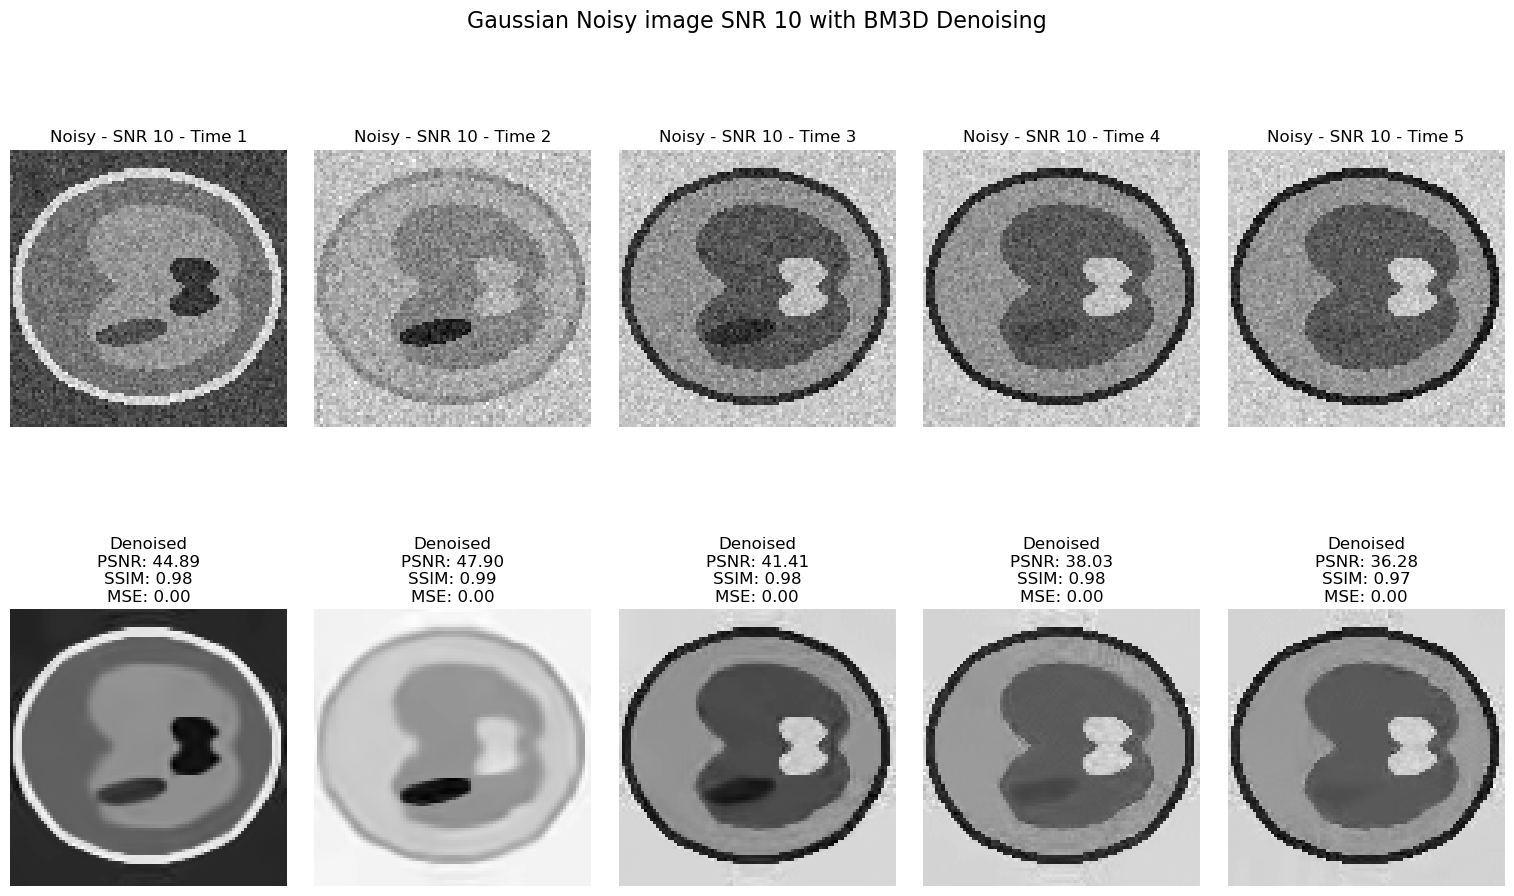

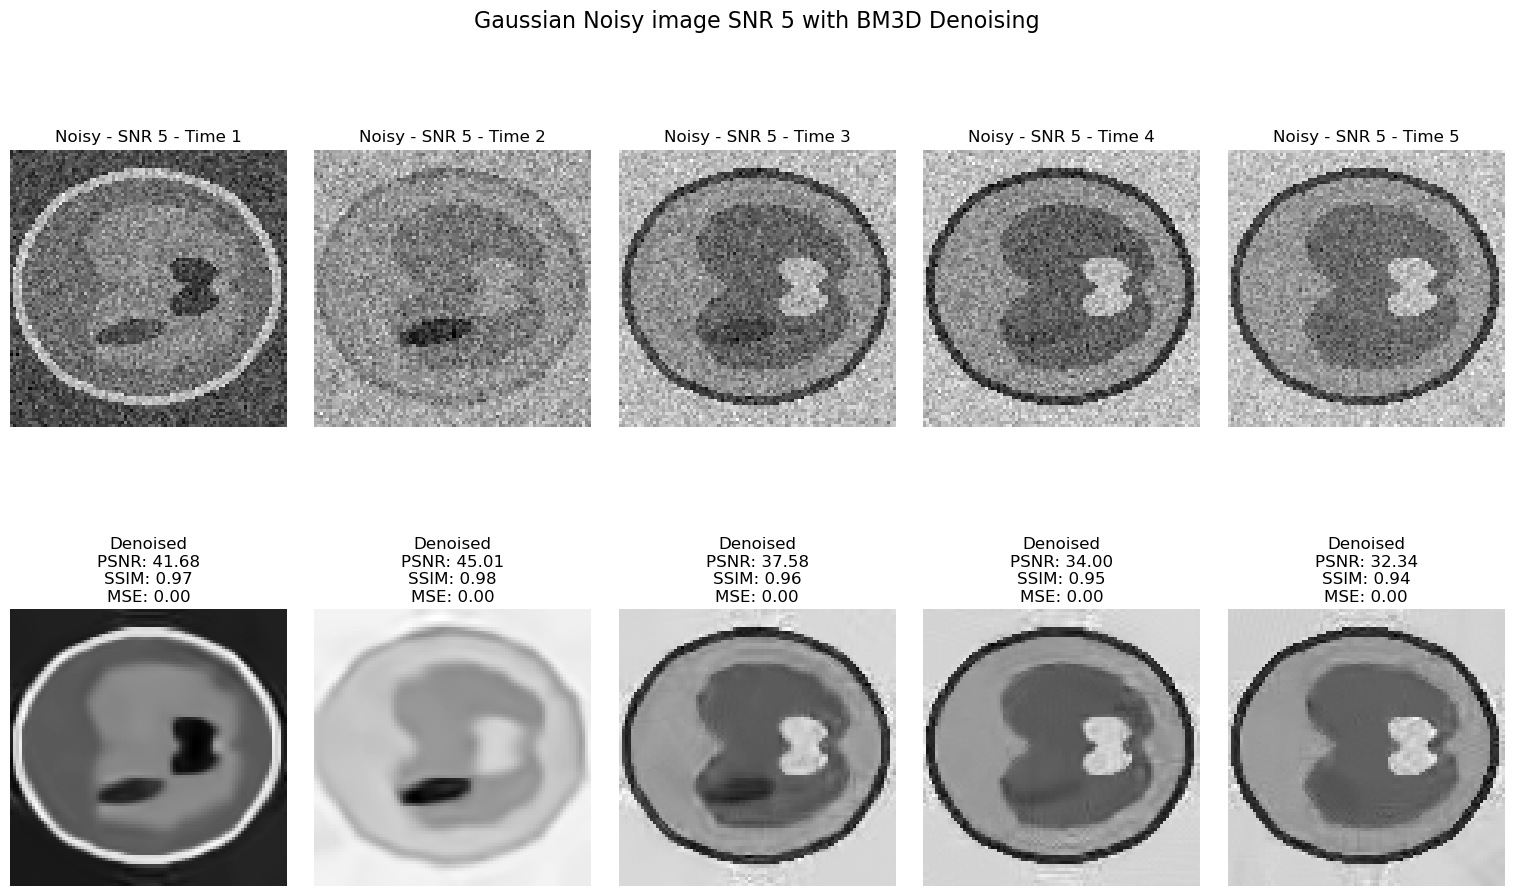

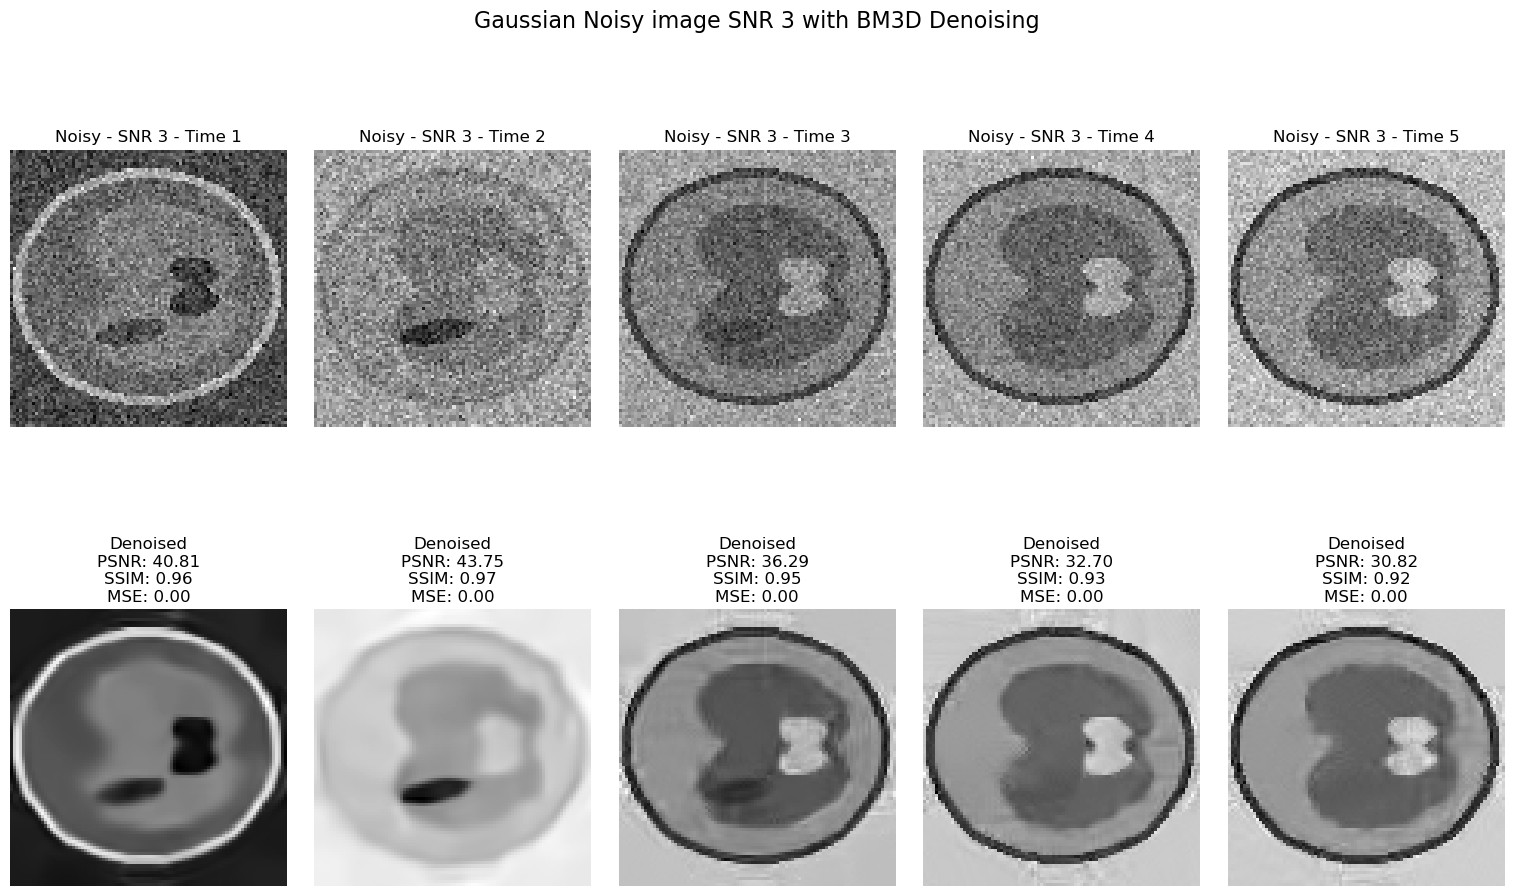

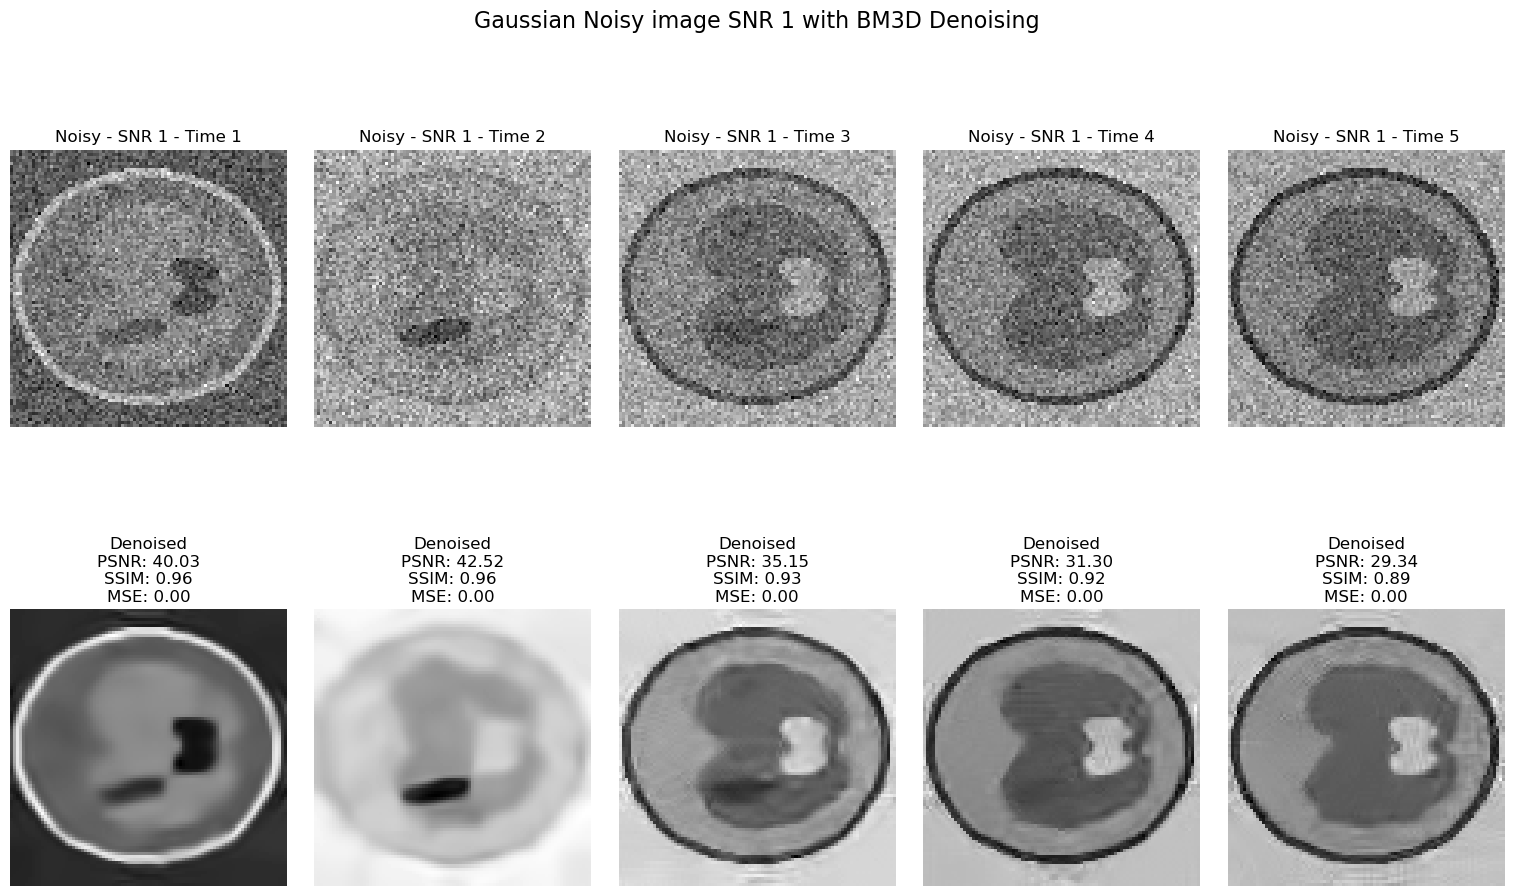

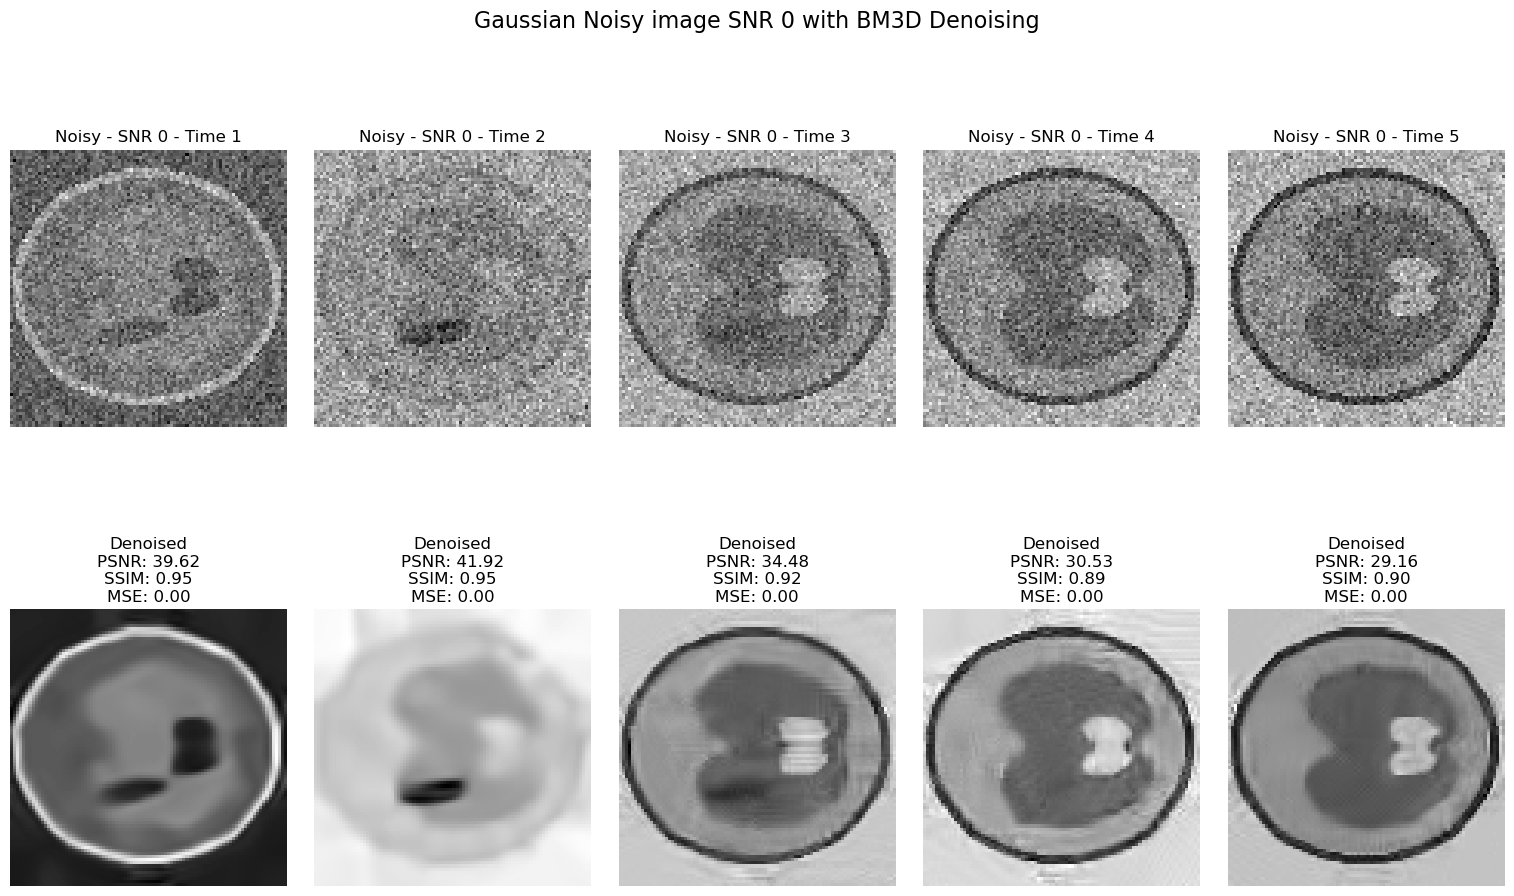

In [48]:
import numpy as np
import matplotlib.pyplot as plt
from skimage.restoration import estimate_sigma
from skimage.color import rgb2gray
from skimage.filters import threshold_otsu
from skimage.segmentation import clear_border
from skimage.measure import label, regionprops
from skimage.metrics import peak_signal_noise_ratio as psnr
from skimage.metrics import structural_similarity as ssim
from skimage.metrics import mean_squared_error as mse
from scipy.stats import entropy as scipy_entropy
from skimage.filters import laplace
import os
import scipy.io
import bm3d


def create_background_mask(image_gray):
    thresh = threshold_otsu(image_gray)
    binary_image = image_gray <= thresh
    cleared_image = clear_border(binary_image)
    label_image = label(cleared_image)
    regions = regionprops(label_image)
    largest_area = 0
    background_label = 0
    for region in regions:
        if region.area > largest_area:
            largest_area = region.area
            background_label = region.label
    background_mask = label_image == background_label
    return background_mask


snrs = [10, 5, 3, 1, 0]

for snr in snrs:
    mat = scipy.io.loadmat(f'/Users/dolorious/Downloads/simulation-1/GroundTruth_gaussian_SNR{snr}.mat')
    mat_ground_truth = scipy.io.loadmat(f'/Users/dolorious/Downloads/simulation-1/GroundTruth.mat')
   
    
    noisy_image_data = mat['data_gaussian']
    ground_truth_data = mat_ground_truth['data']  
     
    evol_time = noisy_image_data.shape[2]
    plt.figure(figsize=(15, 2 * evol_time)) 
   

    for j in range(evol_time):
        noisy_image = noisy_image_data[:, :, j,:]
        ground_truth= ground_truth_data[:, :, j,:]  


        # Convert to grayscale if it's a multichannel image
        if noisy_image.ndim == 3 and noisy_image.shape[2] == 3:
            noisy_image_gray = rgb2gray(noisy_image)
        else:
            noisy_image_gray = noisy_image

        sigma_est = np.mean(estimate_sigma(noisy_image))
        background_mask = create_background_mask(noisy_image_gray)

        # Apply BM3D Denoising
       # denoised_image = bm3d.bm3d(noisy_image_gray, sigma_psd=sigma_est)
        denoised_image = bm3d.bm3d(noisy_image_gray, sigma_psd=sigma_est, stage_arg=bm3d.BM3DStages.ALL_STAGES)
        

        # Calculate standard deviation of the background in the noisy image
        std_deviation_noisy = np.std(noisy_image_gray[background_mask])
        # For denoised image, let's also calculate it for comparison
        std_deviation_denoised = np.std(denoised_image[background_mask])
        ground_truth_gray = rgb2gray(ground_truth)

# Now compute the metrics using the grayscale ground truth
        image_ssim = ssim(ground_truth_gray, denoised_image, data_range=1.0)
        image_psnr = psnr(ground_truth_gray, denoised_image)
        image_mse = mse(ground_truth_gray, denoised_image)
        
        
       


       
        # Display the noisy and denoised images with less space between them
        plt.subplot(2, evol_time, j + 1)
        plt.imshow(noisy_image_gray, cmap='gray')
        plt.title(f'Noisy - SNR {snr} - Time {j+1}')
        plt.axis('off')

        plt.subplot(2, evol_time, evol_time + j + 1)
        plt.imshow(denoised_image, cmap='gray')
        plt.title(f'Denoised\nPSNR: {image_psnr:.2f}\nSSIM: {image_ssim:.2f}\nMSE: {image_mse:.2f}')
        plt.axis('off')

    # Use tight_layout with less padding
    plt.tight_layout(pad=0.2)


    plt.subplots_adjust(wspace=0.1, hspace=0.1)

    plt.subplots_adjust(top=0.88)
    plt.suptitle(f'Gaussian Noisy image SNR {snr} with BM3D Denoising', fontsize=16, y=0.95)
    plt.show()

  


In [ ]:
denoised_image = bm3d.bm3d(image_noisy, sigma_psd=30/255, stage_arg=bm3d.BM3DStages.HARD_THRESHOLDING)

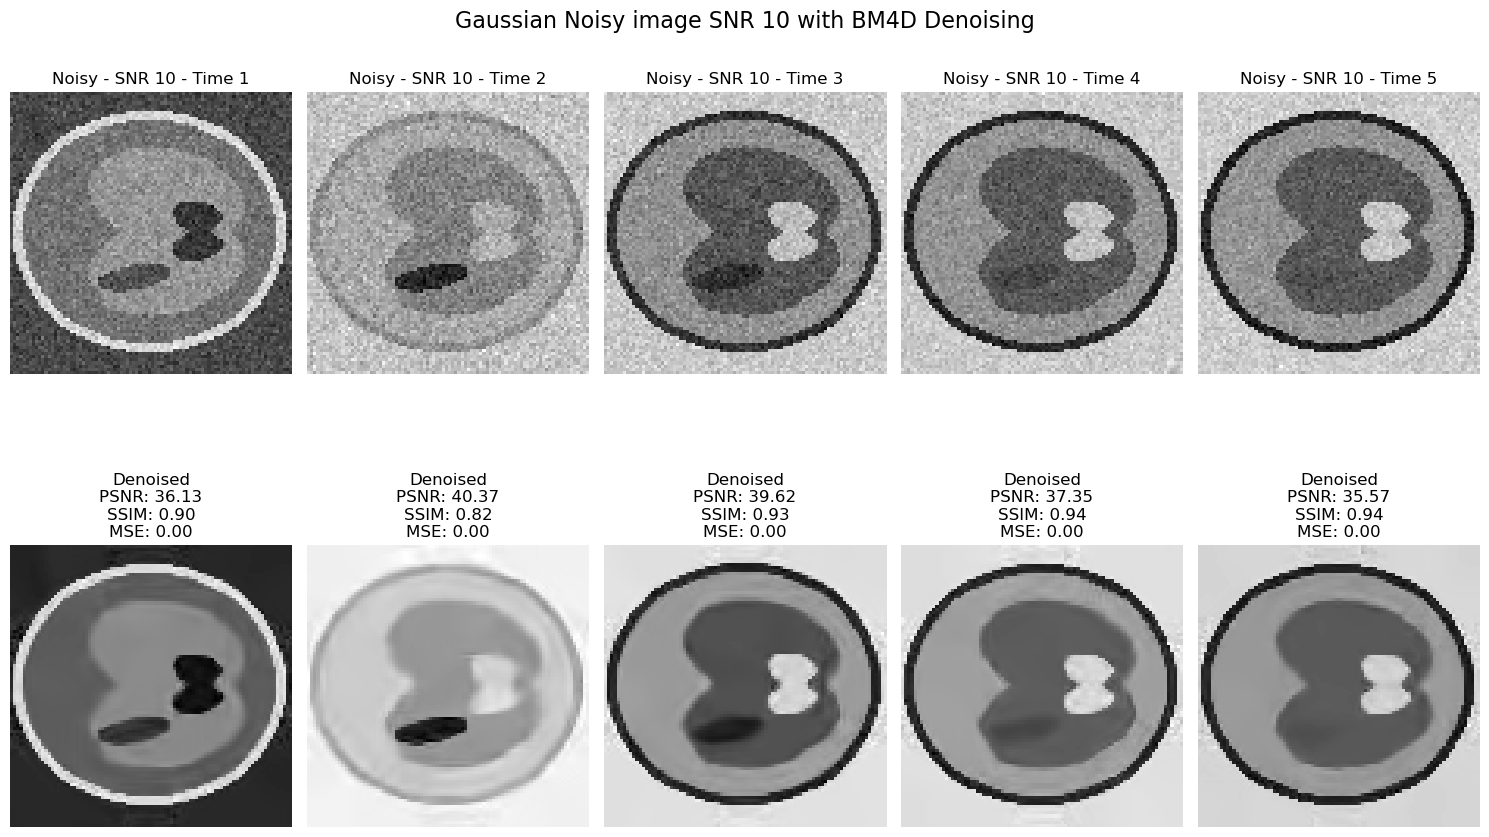

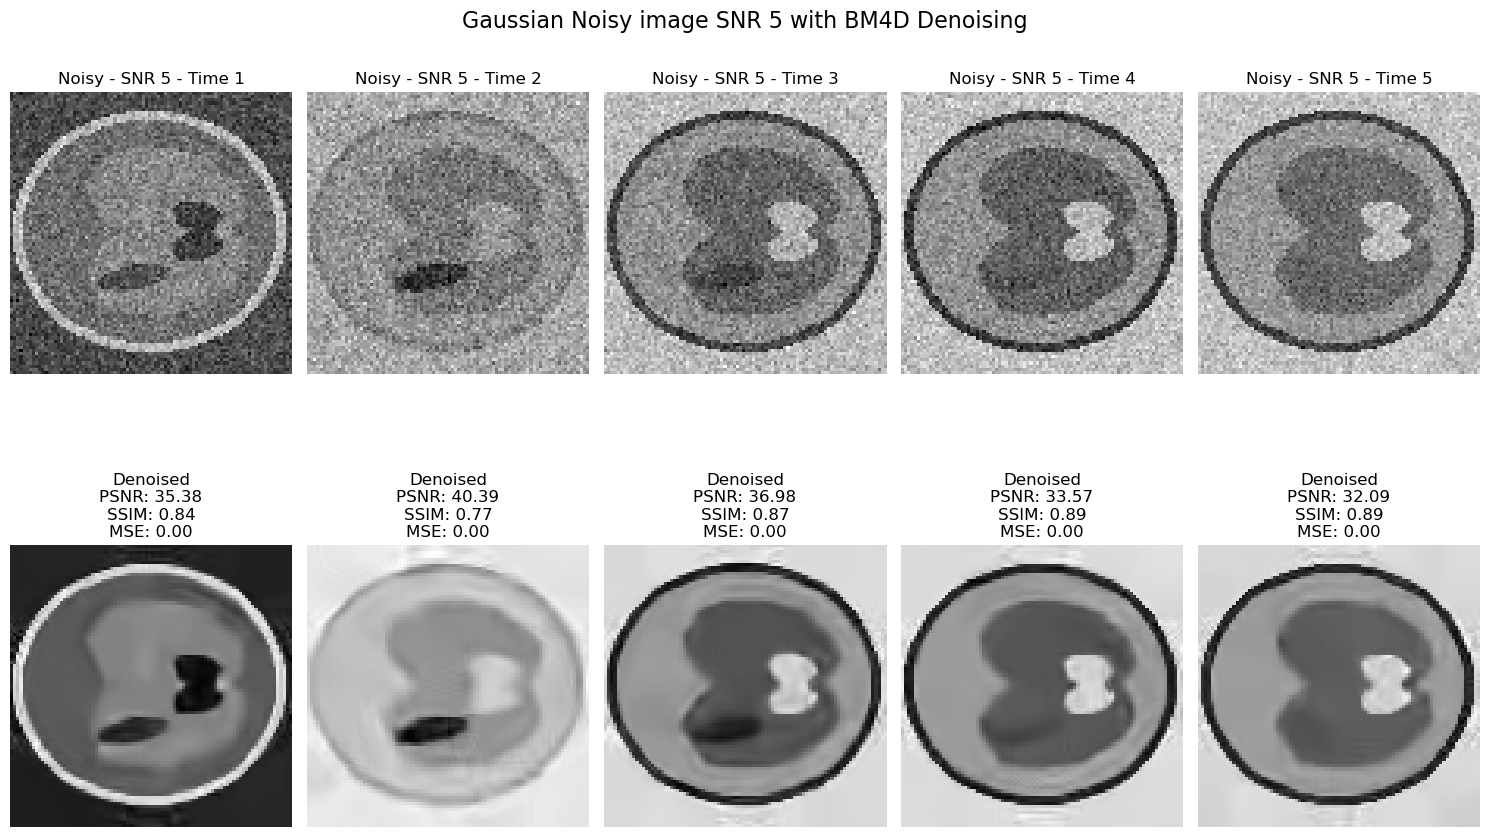

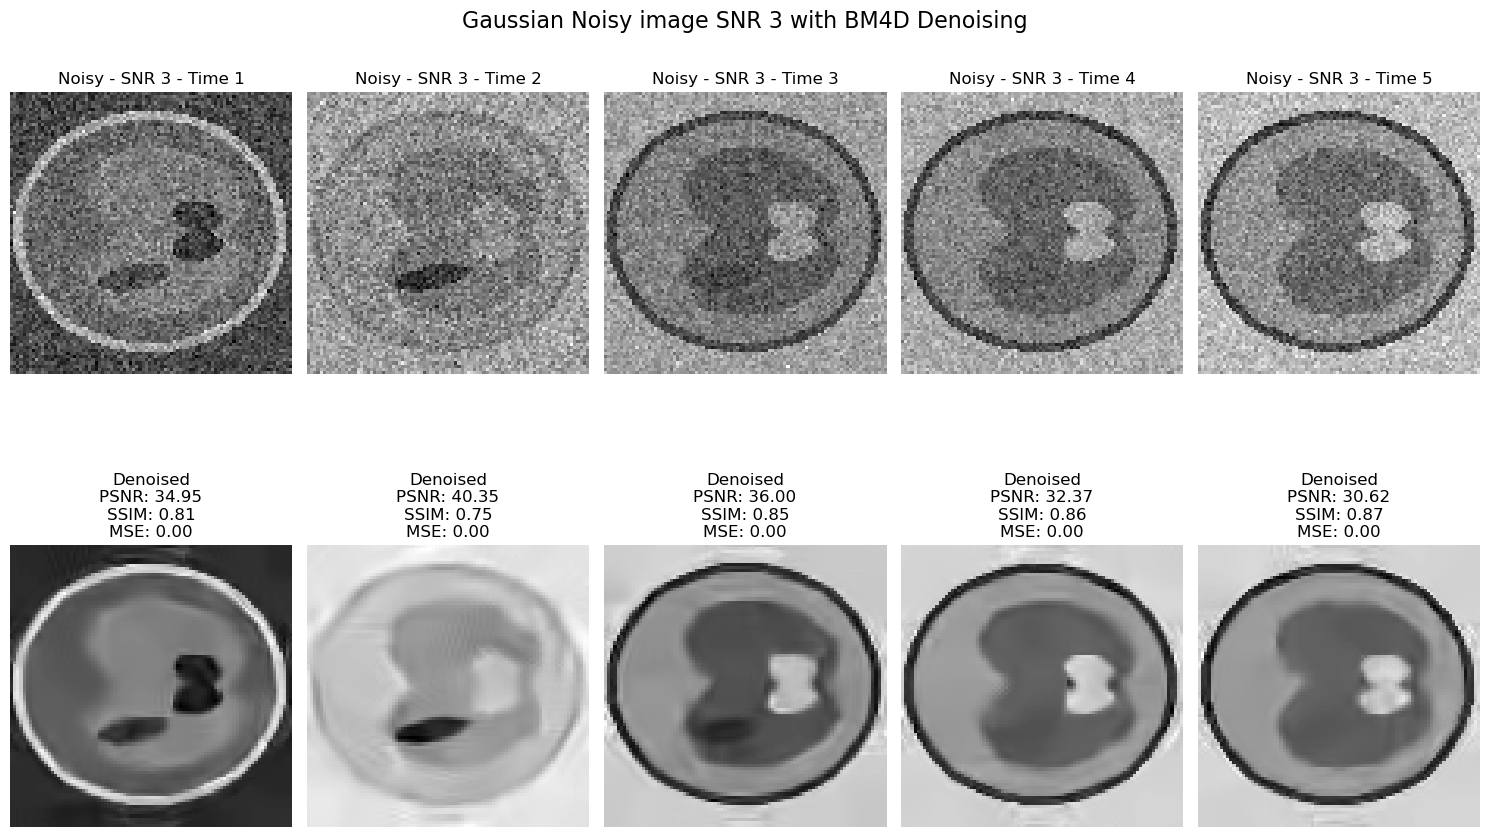

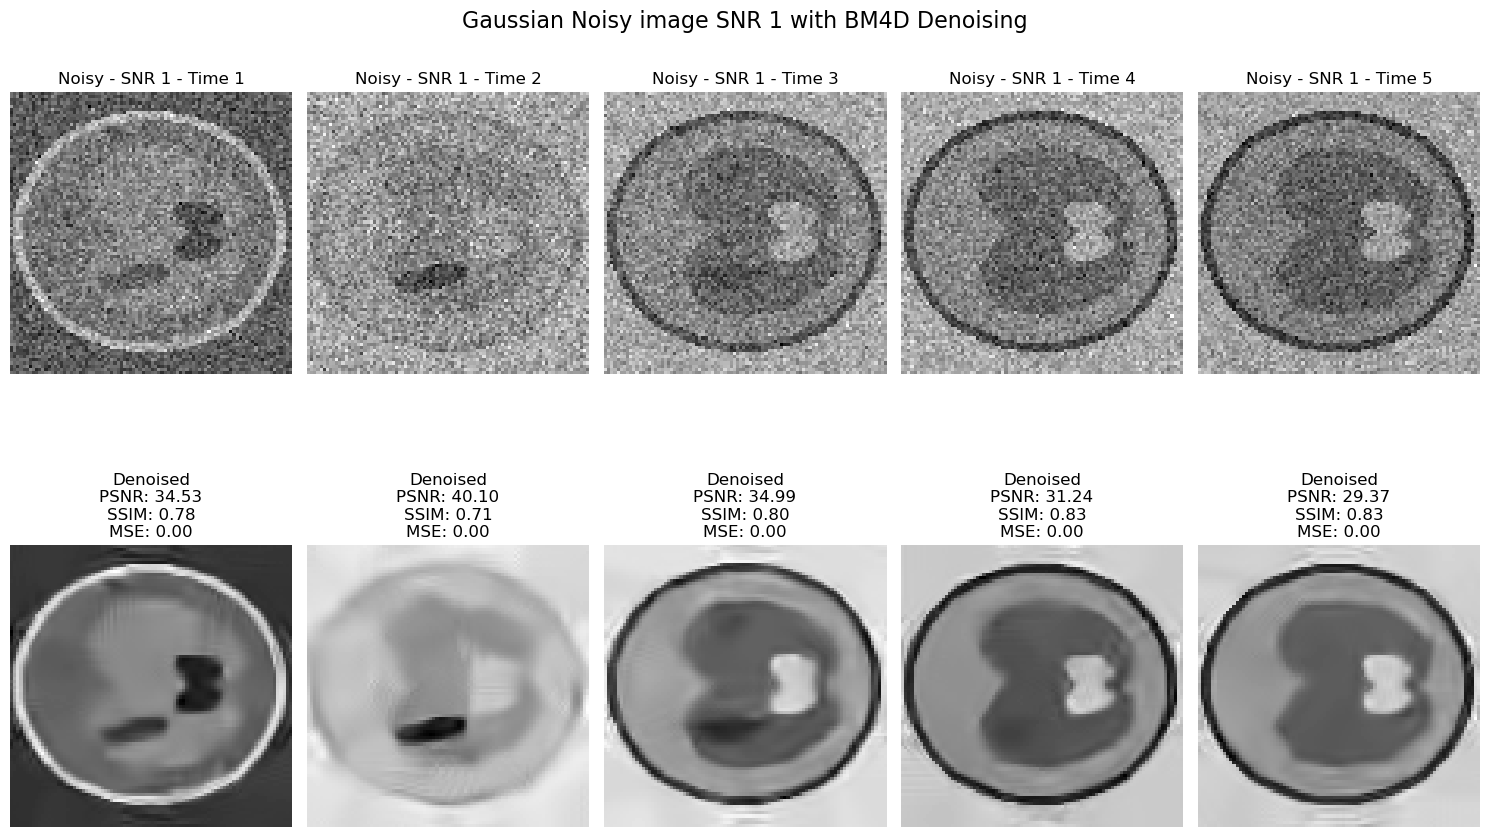

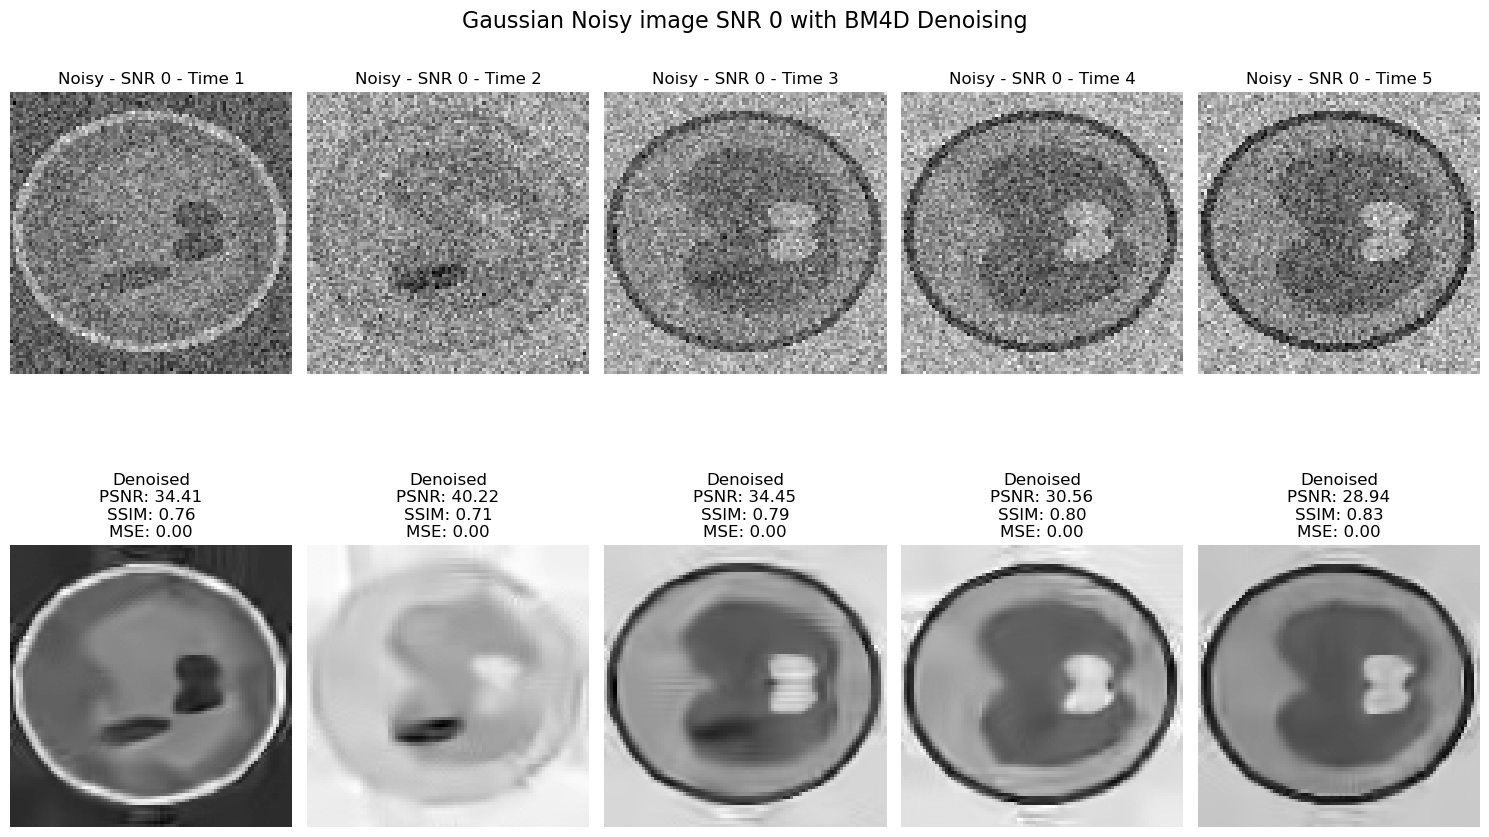

In [6]:
import numpy as np
import matplotlib.pyplot as plt
from skimage.restoration import estimate_sigma
from skimage.color import rgb2gray
from skimage.filters import threshold_otsu
from skimage.segmentation import clear_border
from skimage.measure import label, regionprops
from skimage.metrics import peak_signal_noise_ratio as psnr
from skimage.metrics import structural_similarity as ssim
from skimage.metrics import mean_squared_error as mse
import scipy.io
import bm4d

def create_background_mask(image_gray):
    thresh = threshold_otsu(image_gray)
    binary_image = image_gray <= thresh
    cleared_image = clear_border(binary_image)
    label_image = label(cleared_image)
    regions = regionprops(label_image)
    largest_area = 0
    background_label = 0
    for region in regions:
        if region.area > largest_area:
            largest_area = region.area
            background_label = region.label
    background_mask = label_image == background_label
    return background_mask




snrs = [10, 5, 3, 1, 0]

for snr in snrs:
    mat = scipy.io.loadmat(f'/Users/dolorious/Downloads/simulation-1/GroundTruth_gaussian_SNR{snr}.mat')
    mat_ground_truth = scipy.io.loadmat(f'/Users/dolorious/Downloads/simulation-1/GroundTruth.mat')
   
    noisy_image_data = mat['data_gaussian']
    ground_truth_data = mat_ground_truth['data']

    plt.figure(figsize=(15, 2 * evol_time)) 

    evol_time = noisy_image_data.shape[2]  
    for j in range(evol_time):
        noisy_image = noisy_image_data[:, :, j]
        ground_truth = ground_truth_data[:, :,j]  

        # Convert to grayscale if it's a multichannel image
        if noisy_image.ndim == 3 and noisy_image.shape[2] == 3:
            noisy_image_gray = rgb2gray(noisy_image)
        else:
            noisy_image_gray = noisy_image.mean(axis=2)

        sigma_est = np.mean(estimate_sigma(noisy_image_gray, channel_axis=-1))
        background_mask = create_background_mask(noisy_image_gray)

        # Apply BM4D Denoising
        denoised_image = bm4d.bm4d(noisy_image_gray, sigma_psd=sigma_est)
        denoised_image = np.squeeze(denoised_image)

        # Calculate standard deviation of the background in the noisy image
        std_deviation_noisy = np.std(noisy_image_gray[background_mask])
        # For denoised image, let's also calculate it for comparison
        std_deviation_denoised = np.std(denoised_image[background_mask])

        # Convert ground truth to grayscale
        if ground_truth.ndim == 3 and ground_truth.shape[2] > 1:
            ground_truth_gray = ground_truth.mean(axis=2)
        else:
            ground_truth_gray = ground_truth

        ground_truth_gray = np.squeeze(ground_truth_gray)

        # Ensure both ground_truth_gray and denoised_image have the same number of dimensions
        if ground_truth_gray.ndim != denoised_image.ndim:
            if ground_truth_gray.ndim < denoised_image.ndim:
                ground_truth_gray = np.expand_dims(ground_truth_gray, axis=-1)
            else:
                ground_truth_gray = np.squeeze(ground_truth_gray)

        # Compute the metrics
        image_ssim = ssim(ground_truth_gray, denoised_image, data_range=ground_truth_gray.max() - ground_truth_gray.min())
        image_psnr = psnr(ground_truth_gray, denoised_image)
        image_mse = mse(ground_truth_gray, denoised_image)
        
       

        
        # Display the noisy and denoised images with less space between them
        plt.subplot(2, evol_time, j + 1)
        plt.imshow(noisy_image_gray, cmap='gray')
        plt.title(f'Noisy - SNR {snr} - Time {j+1}')
        plt.axis('off')

        plt.subplot(2, evol_time, evol_time + j + 1)
        plt.imshow(denoised_image, cmap='gray')
        plt.title(f'Denoised\nPSNR: {image_psnr:.2f}\nSSIM: {image_ssim:.2f}\nMSE: {image_mse:.2f}')
        plt.axis('off')

    plt.subplots_adjust(wspace=0.1, hspace=0.1)  # Adjust the spacing between subplots
    plt.tight_layout()  # No arguments needed
    plt.suptitle(f'Gaussian Noisy image SNR {snr} with BM4D Denoising', fontsize=16, y=0.95)
    plt.show()


/var/folders/vl/tld4y4295dvbpfhgzk8mrvkc0000gn/T/ipykernel_43438/3042917535.py:57: UserWarning: image is size 3 on the last axis, but channel_axis is None. If this is a color image, please set channel_axis=-1 for proper noise estimation.
  sigma_est = np.mean(estimate_sigma(noisy_image))


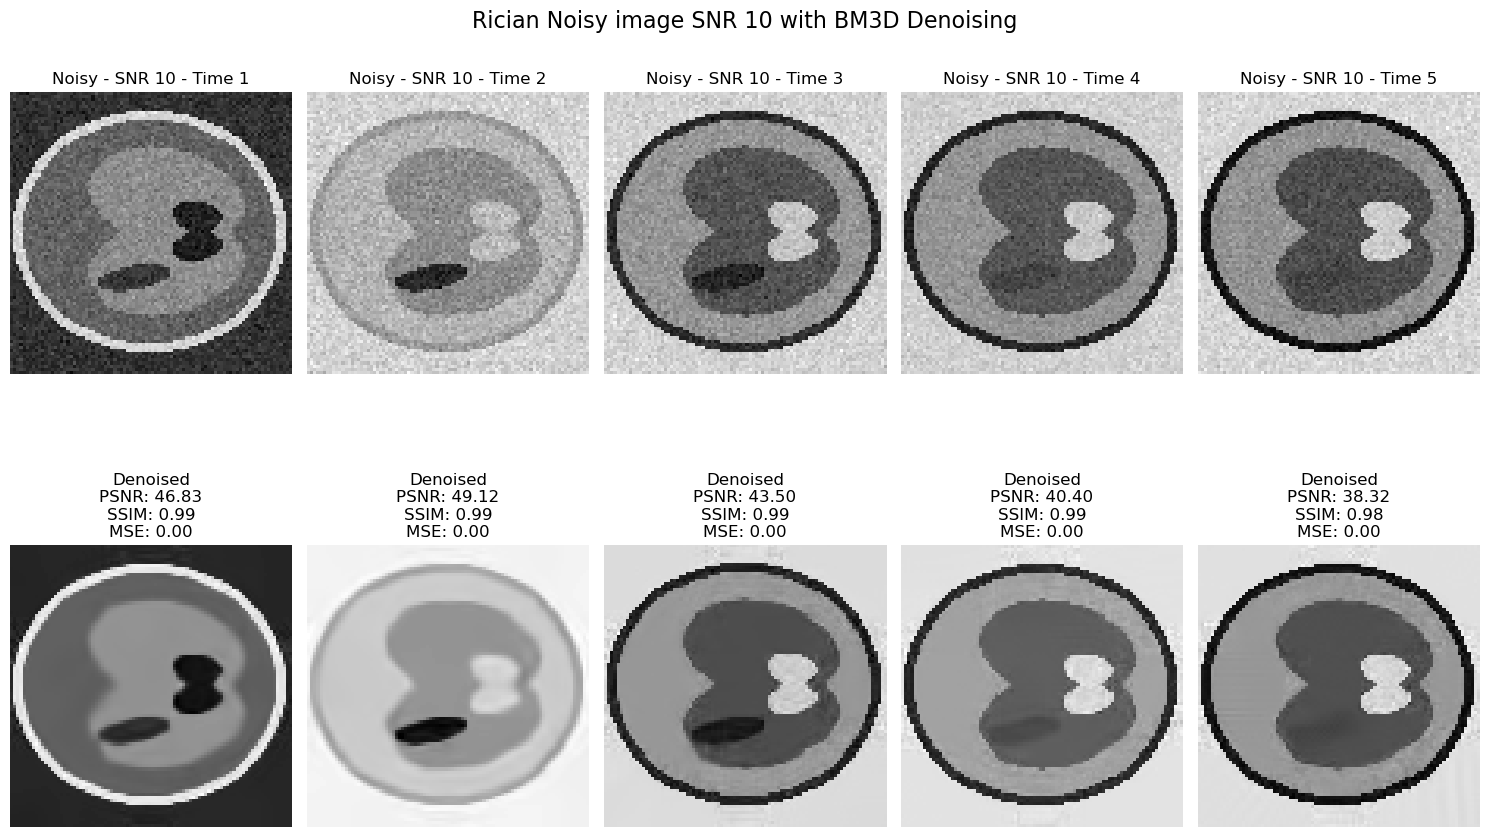

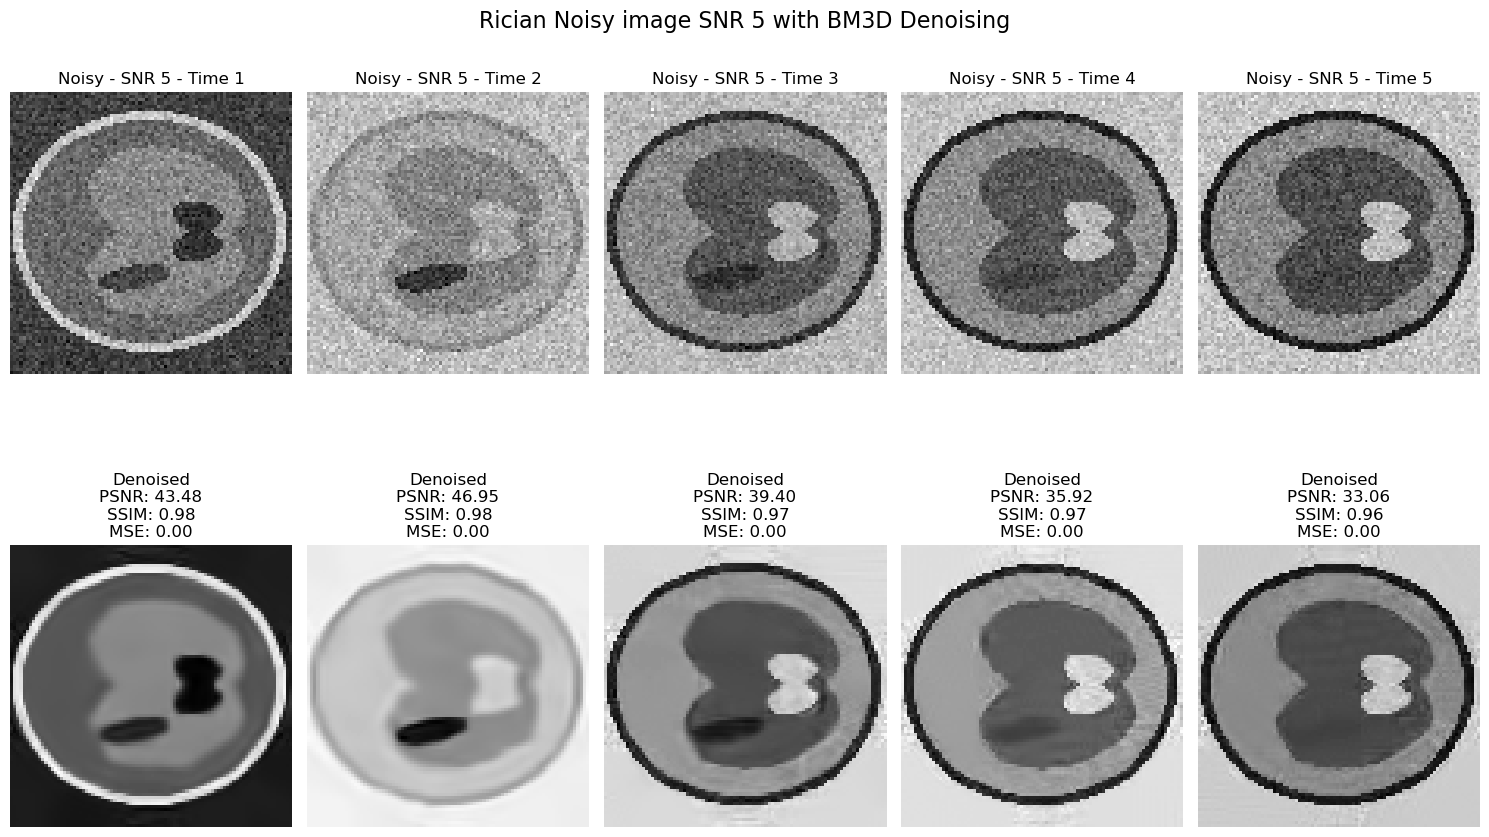

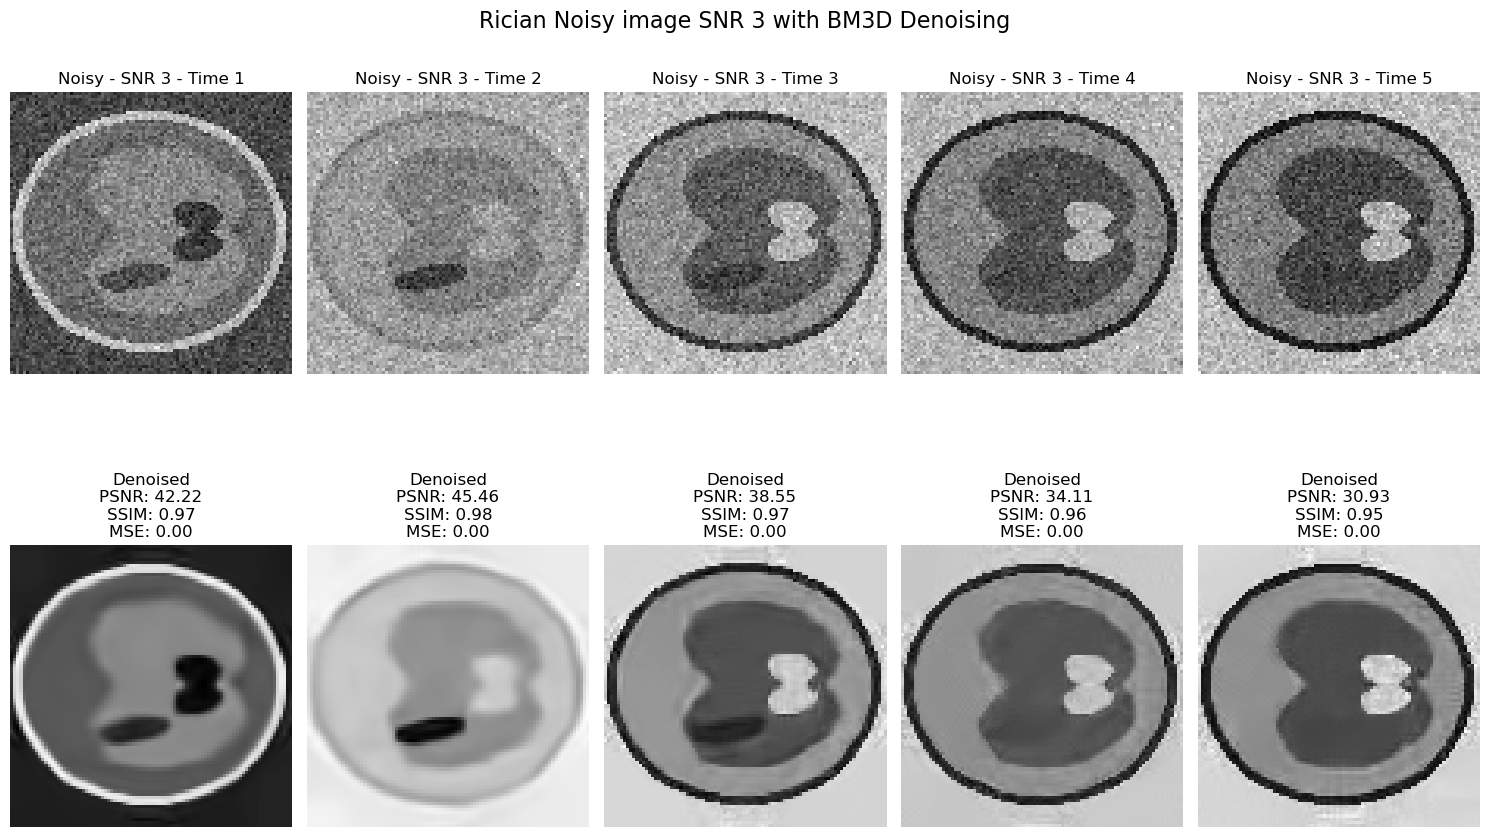

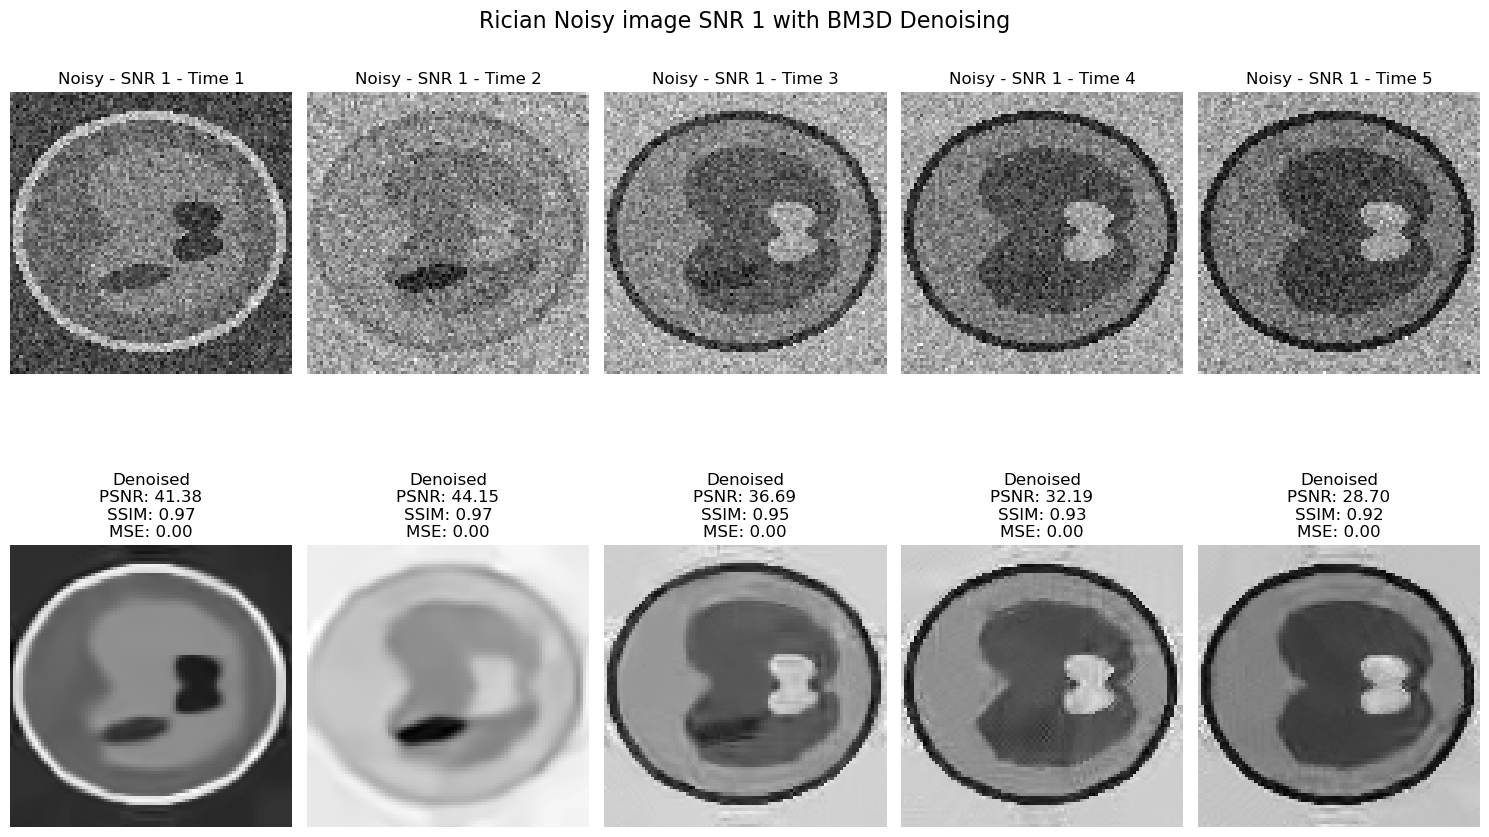

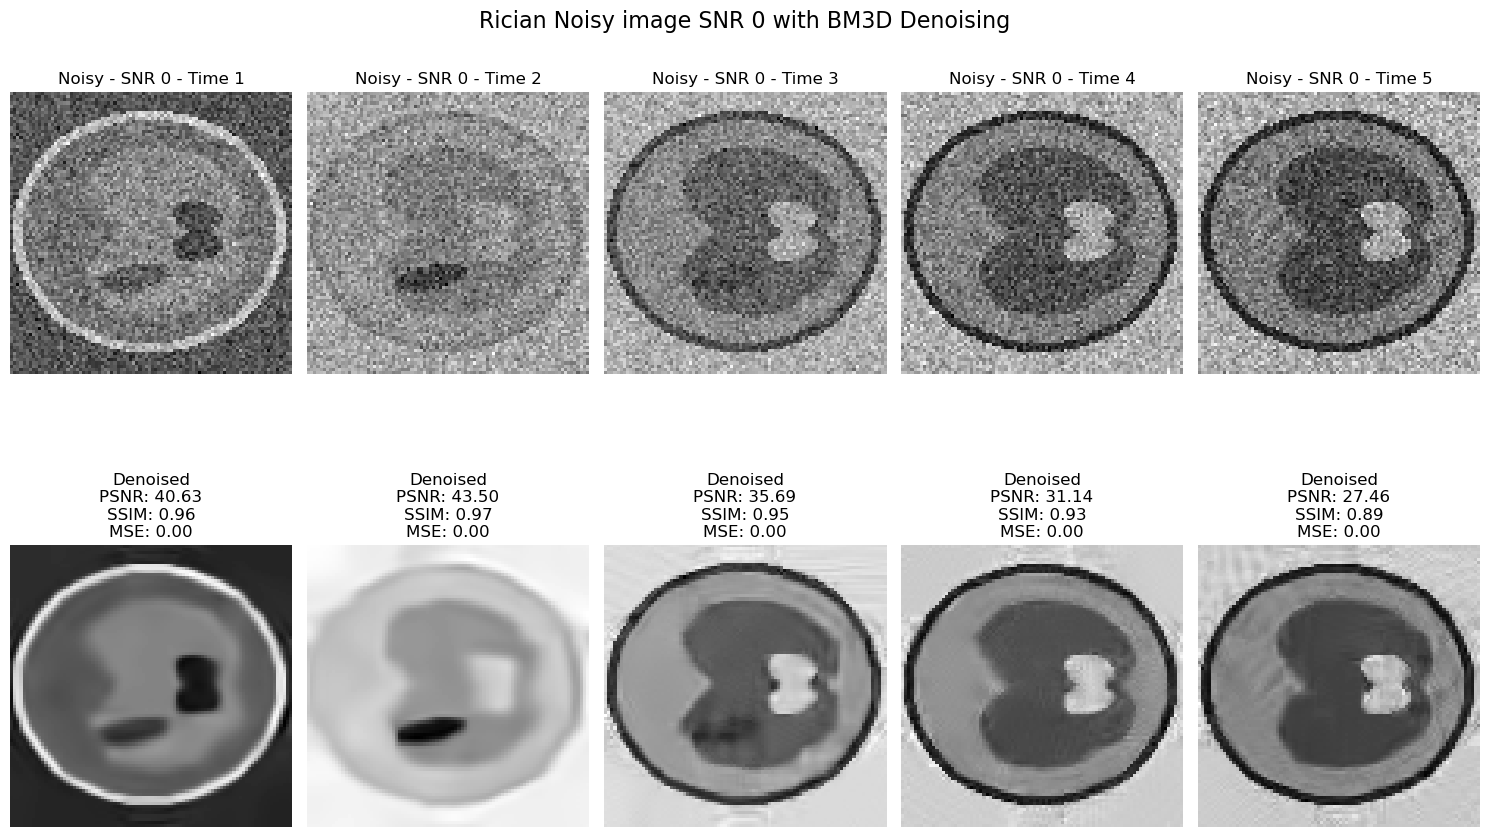

In [47]:
import numpy as np
import matplotlib.pyplot as plt
from skimage.restoration import estimate_sigma
from skimage.color import rgb2gray
from skimage.filters import threshold_otsu
from skimage.segmentation import clear_border
from skimage.measure import label, regionprops
from skimage.metrics import peak_signal_noise_ratio as psnr
from skimage.metrics import structural_similarity as ssim
from skimage.metrics import mean_squared_error as mse
from scipy.stats import entropy as scipy_entropy
from skimage.filters import laplace
import os
import scipy.io
import bm3d


def create_background_mask(image_gray):
    thresh = threshold_otsu(image_gray)
    binary_image = image_gray <= thresh
    cleared_image = clear_border(binary_image)
    label_image = label(cleared_image)
    regions = regionprops(label_image)
    largest_area = 0
    background_label = 0
    for region in regions:
        if region.area > largest_area:
            largest_area = region.area
            background_label = region.label
    background_mask = label_image == background_label
    return background_mask


snrs = [10, 5, 3, 1, 0]

for snr in snrs:
    mat = scipy.io.loadmat(f'/Users/dolorious/Downloads/simulation-1/GroundTruth_rician_SNR{snr}.mat')
    mat_ground_truth = scipy.io.loadmat(f'/Users/dolorious/Downloads/simulation-1/GroundTruth.mat')
   
    
    noisy_image_data = mat['data_rician']
    ground_truth_data = mat_ground_truth['data']  # Correct key here
    plt.figure(figsize=(15, 2 * evol_time)) 

    evol_time = noisy_image_data.shape[2]
    for j in range(evol_time):
        noisy_image = noisy_image_data[:, :, j]
        ground_truth= ground_truth_data[:, :, j]  # Assuming same indexing as noisy images


        # Convert to grayscale if it's a multichannel image
        if noisy_image.ndim == 3 and noisy_image.shape[2] == 3:
            noisy_image_gray = rgb2gray(noisy_image)
        else:
            noisy_image_gray = noisy_image

        sigma_est = np.mean(estimate_sigma(noisy_image))
        background_mask = create_background_mask(noisy_image_gray)

        # Apply BM3D Denoising
        denoised_image = bm3d.bm3d(noisy_image_gray, sigma_psd=sigma_est, stage_arg=bm3d.BM3DStages.ALL_STAGES)
        

        std_deviation_noisy = np.std(noisy_image_gray[background_mask])
    
        std_deviation_denoised = np.std(denoised_image[background_mask])
        ground_truth_gray = rgb2gray(ground_truth)

# Now compute the metrics using the grayscale ground truth
        image_ssim = ssim(ground_truth_gray, denoised_image, data_range=1.0)
        image_psnr = psnr(ground_truth_gray, denoised_image)
        image_mse = mse(ground_truth_gray, denoised_image)
       

        plt.subplot(2, evol_time, j + 1)
        plt.imshow(noisy_image_gray, cmap='gray')
        plt.title(f'Noisy - SNR {snr} - Time {j+1}')
        plt.axis('off')

        plt.subplot(2, evol_time, evol_time + j + 1)
        plt.imshow(denoised_image, cmap='gray')
        plt.title(f'Denoised\nPSNR: {image_psnr:.2f}\nSSIM: {image_ssim:.2f}\nMSE: {image_mse:.2f}')
        plt.axis('off')

    plt.subplots_adjust(wspace=0.1, hspace=0.1)  
    plt.tight_layout()  
    plt.suptitle(f'Rician Noisy image SNR {snr} with BM3D Denoising', fontsize=16, y=0.95)
    plt.show()


  




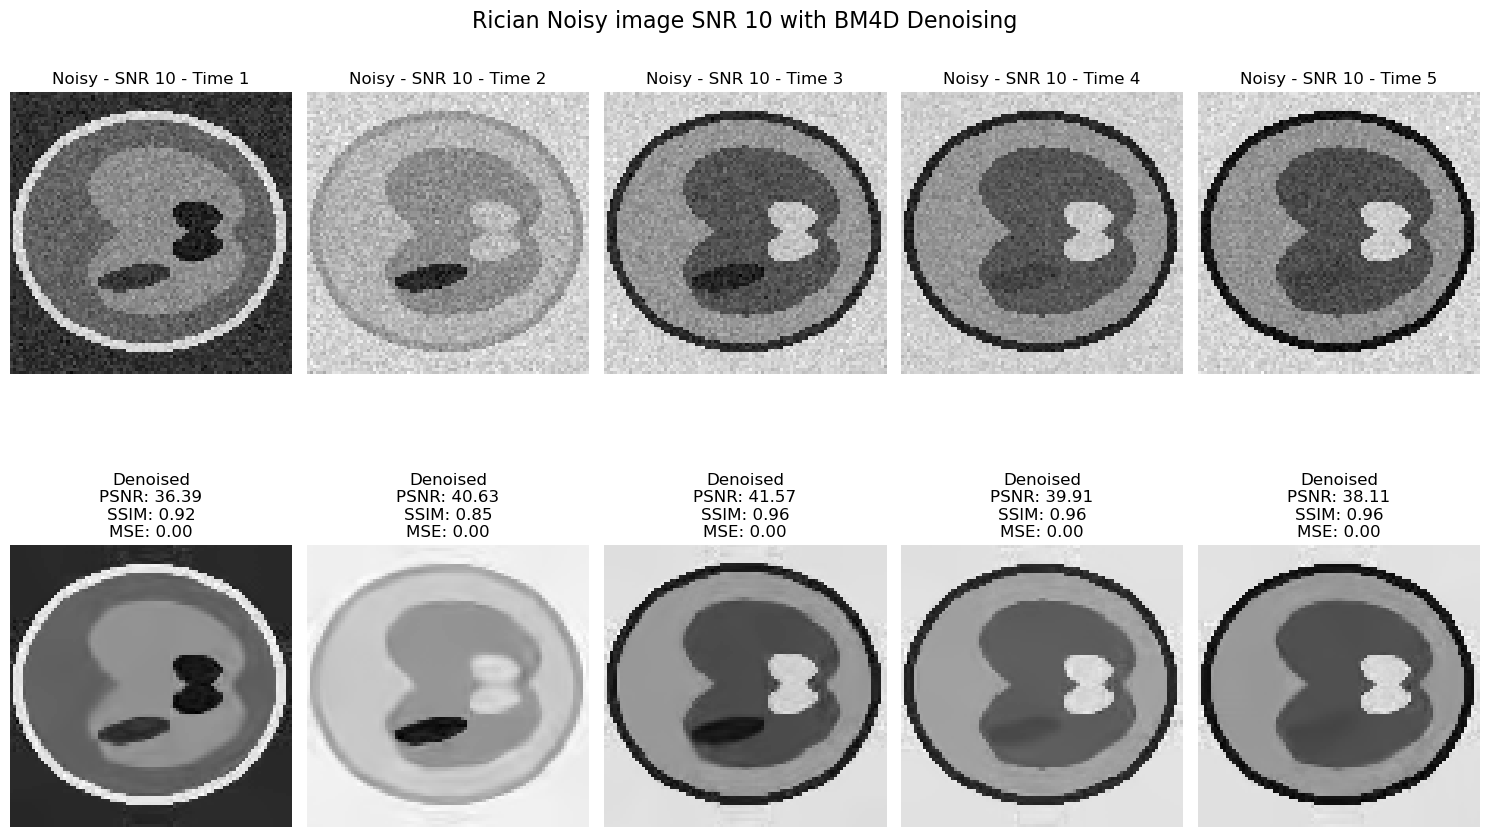

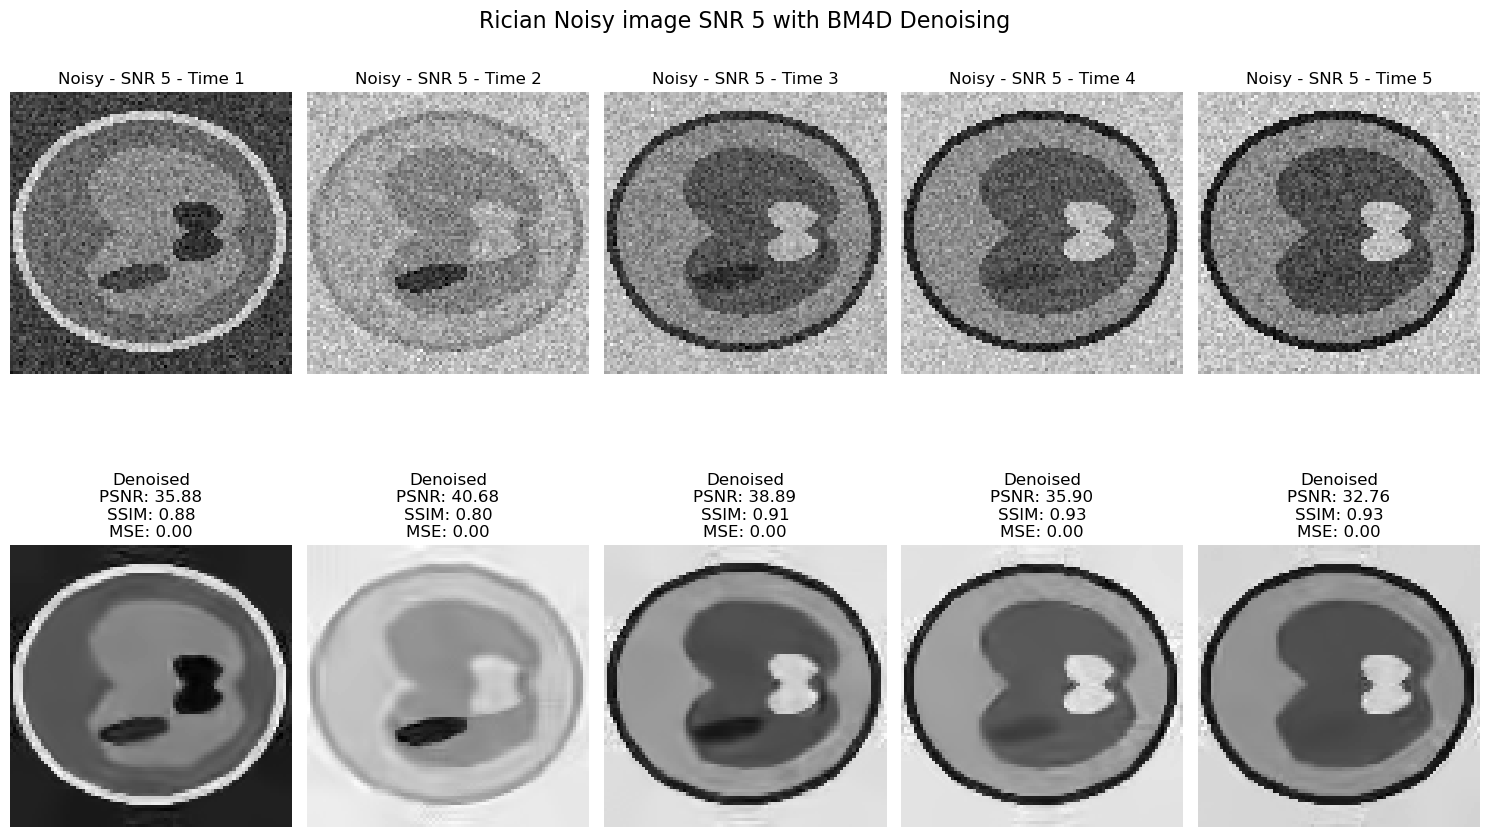

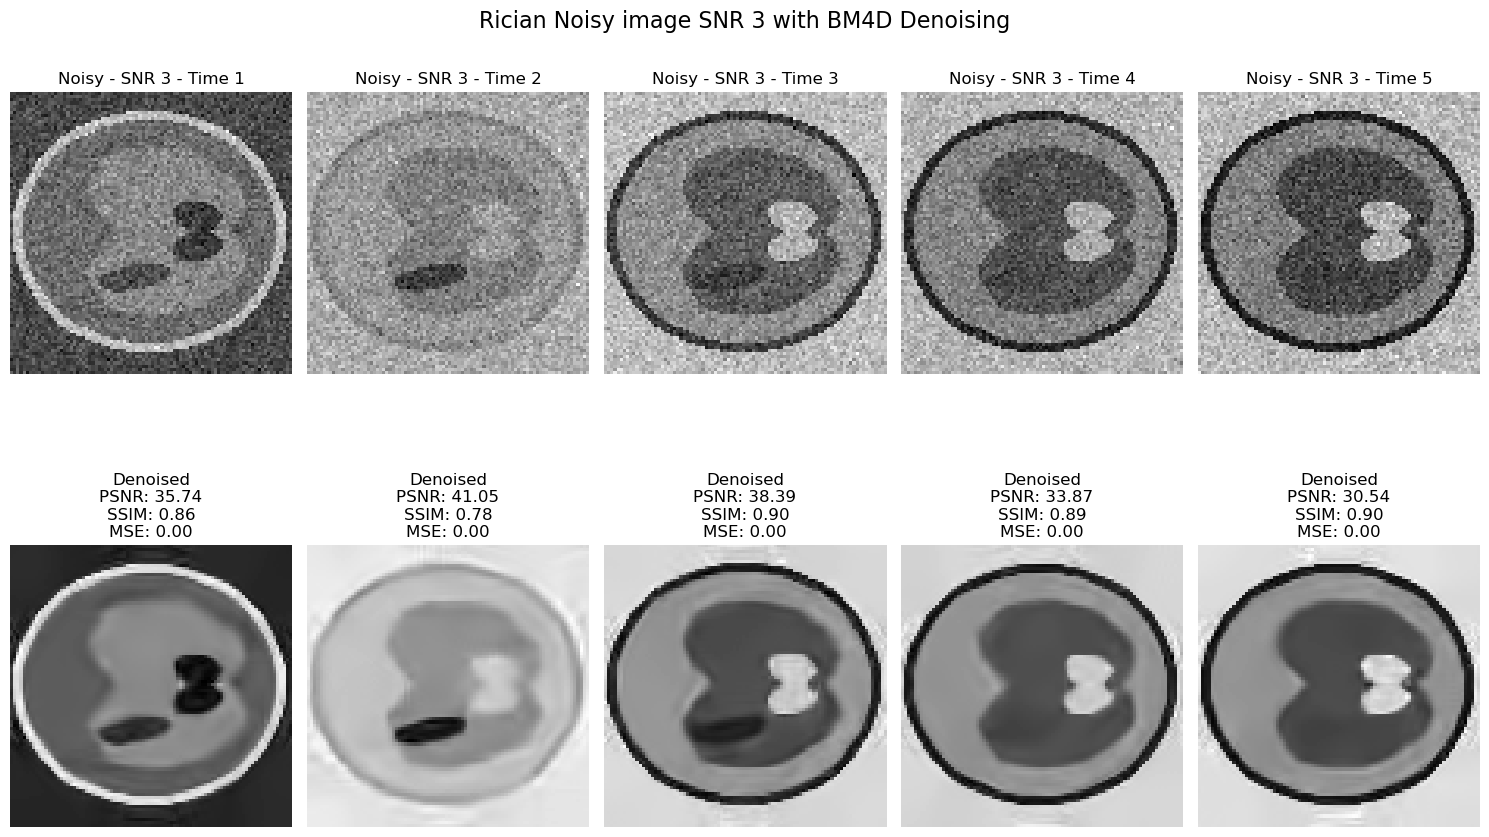

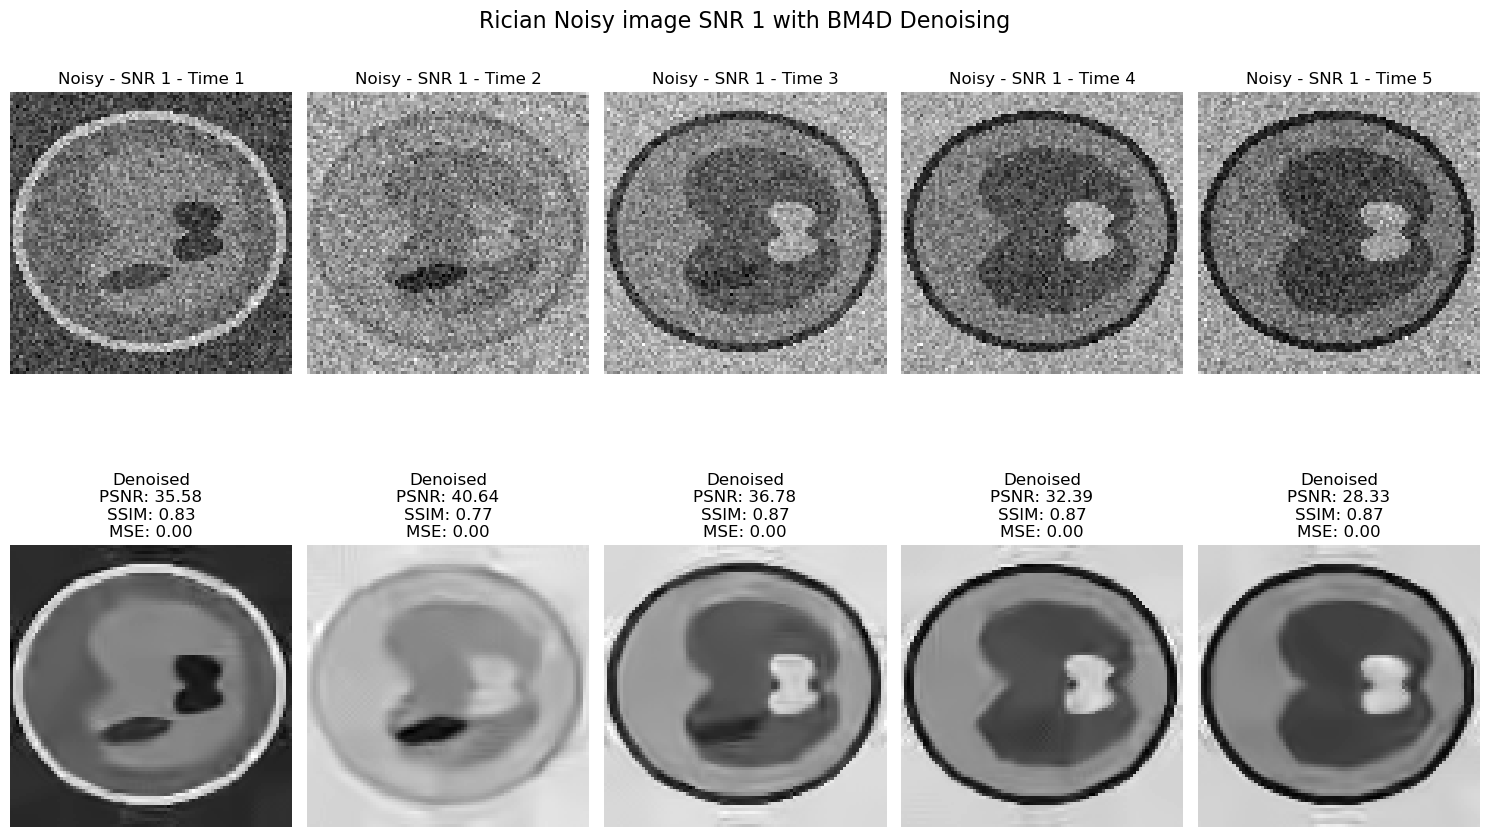

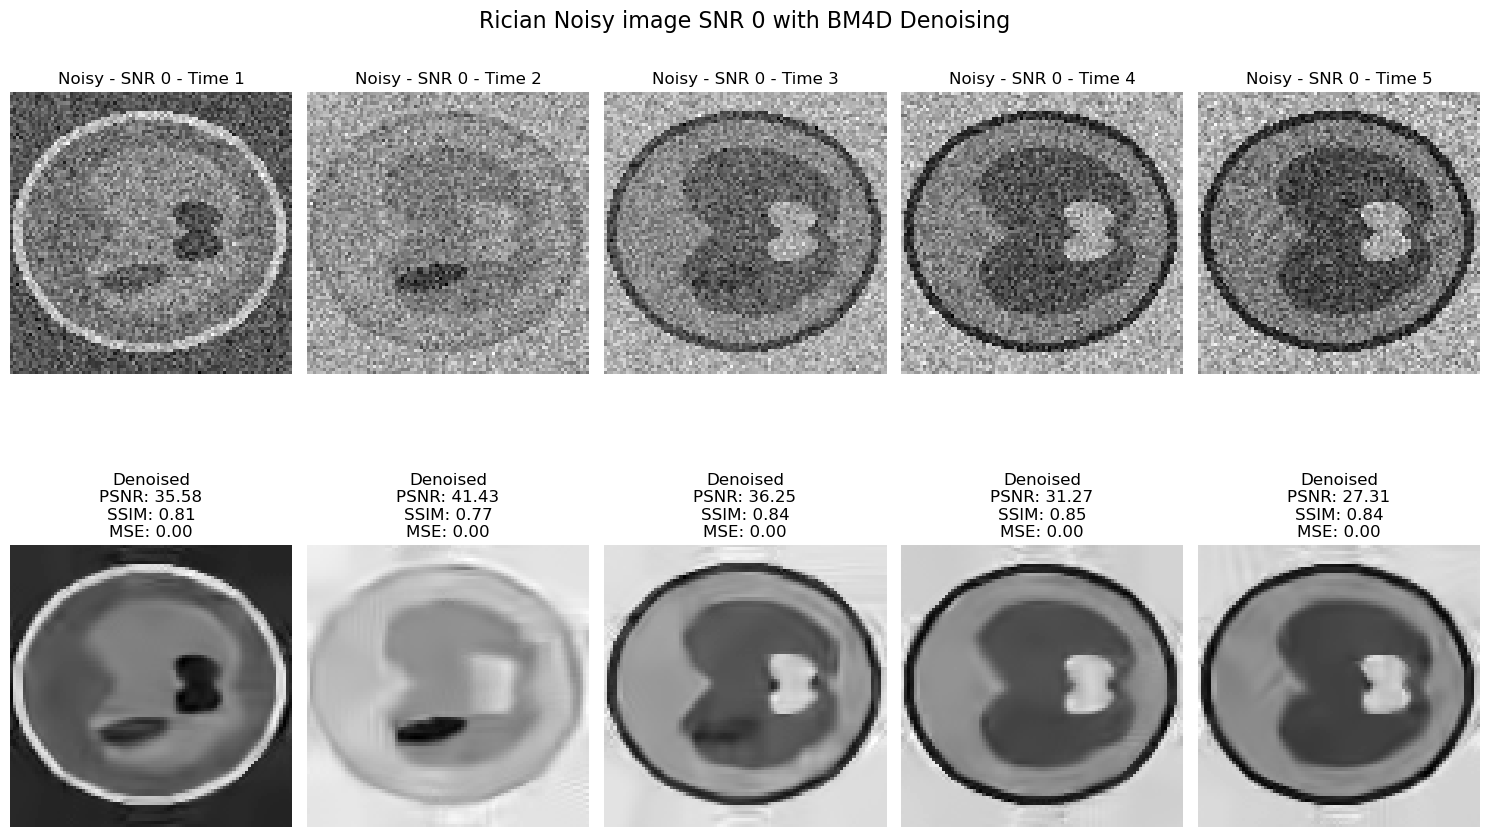

In [46]:
import numpy as np
import matplotlib.pyplot as plt
from skimage.restoration import estimate_sigma
from skimage.color import rgb2gray
from skimage.filters import threshold_otsu
from skimage.segmentation import clear_border
from skimage.measure import label, regionprops
from skimage.metrics import peak_signal_noise_ratio as psnr
from skimage.metrics import structural_similarity as ssim
from skimage.metrics import mean_squared_error as mse
import scipy.io
import bm4d

def create_background_mask(image_gray):
    thresh = threshold_otsu(image_gray)
    binary_image = image_gray <= thresh
    cleared_image = clear_border(binary_image)
    label_image = label(cleared_image)
    regions = regionprops(label_image)
    largest_area = 0
    background_label = 0
    for region in regions:
        if region.area > largest_area:
            largest_area = region.area
            background_label = region.label
    background_mask = label_image == background_label
    return background_mask




snrs = [10, 5, 3, 1, 0]

for snr in snrs:
    mat = scipy.io.loadmat(f'/Users/dolorious/Downloads/simulation-1/GroundTruth_rician_SNR{snr}.mat')
    mat_ground_truth = scipy.io.loadmat(f'/Users/dolorious/Downloads/simulation-1/GroundTruth.mat')
   
    noisy_image_data = mat['data_rician']
    ground_truth_data = mat_ground_truth['data']

    plt.figure(figsize=(15, 2 * evol_time)) 

    evol_time = noisy_image_data.shape[2]  
    for j in range(evol_time):
        noisy_image = noisy_image_data[:, :, j]
        ground_truth = ground_truth_data[:, :,j]  

        # Convert to grayscale if it's a multichannel image
        if noisy_image.ndim == 3 and noisy_image.shape[2] == 3:
            noisy_image_gray = rgb2gray(noisy_image)
        else:
            noisy_image_gray = noisy_image.mean(axis=2)

        sigma_est = np.mean(estimate_sigma(noisy_image_gray, channel_axis=-1))
        background_mask = create_background_mask(noisy_image_gray)

        # Apply BM4D Denoising
        denoised_image = bm4d.bm4d(noisy_image_gray, sigma_psd=sigma_est)
        denoised_image = np.squeeze(denoised_image)

        # Calculate standard deviation of the background in the noisy image
        std_deviation_noisy = np.std(noisy_image_gray[background_mask])
        # For denoised image, let's also calculate it for comparison
        std_deviation_denoised = np.std(denoised_image[background_mask])

        # Convert ground truth to grayscale
        if ground_truth.ndim == 3 and ground_truth.shape[2] > 1:
            ground_truth_gray = ground_truth.mean(axis=2)
        else:
            ground_truth_gray = ground_truth

        ground_truth_gray = np.squeeze(ground_truth_gray)

        # Ensure both ground_truth_gray and denoised_image have the same number of dimensions
        if ground_truth_gray.ndim != denoised_image.ndim:
            if ground_truth_gray.ndim < denoised_image.ndim:
                ground_truth_gray = np.expand_dims(ground_truth_gray, axis=-1)
            else:
                ground_truth_gray = np.squeeze(ground_truth_gray)

        # Compute the metrics
        image_ssim = ssim(ground_truth_gray, denoised_image, data_range=ground_truth_gray.max() - ground_truth_gray.min())
        image_psnr = psnr(ground_truth_gray, denoised_image)
        image_mse = mse(ground_truth_gray, denoised_image)
        
       

        
        # Display the noisy and denoised images with less space between them
        plt.subplot(2, evol_time, j + 1)
        plt.imshow(noisy_image_gray, cmap='gray')
        plt.title(f'Noisy - SNR {snr} - Time {j+1}')
        plt.axis('off')

        plt.subplot(2, evol_time, evol_time + j + 1)
        plt.imshow(denoised_image, cmap='gray')
        plt.title(f'Denoised\nPSNR: {image_psnr:.2f}\nSSIM: {image_ssim:.2f}\nMSE: {image_mse:.2f}')
        plt.axis('off')

    plt.subplots_adjust(wspace=0.1, hspace=0.1)  # Adjust the spacing between subplots
    plt.tight_layout()  # No arguments needed
    plt.suptitle(f'Rician Noisy image SNR {snr} with BM4D Denoising', fontsize=16, y=0.95)
    plt.show()
